Code for exploratory data analysis

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from lifelines import CoxPHFitter

In [2]:
conn = sqlite3.connect(r'C:\work\database\techTest.db')

List all tables in the database

In [3]:
tables_df = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables = tables_df['name'].tolist()
print("Tables in the database are:", tables)

Tables in the database are: ['patient', 'diagnosis', 'biomarker']


Schema for tables in the database

In [4]:
dfs = {}
for t in tables:
    df = pd.read_sql(f"SELECT * FROM {t}", conn)
    dfs[t] = df
    print(f"\nSchema for table '{t}' is :")
    print(df.dtypes)


Schema for table 'patient' is :
patient_id    object
dob           object
dod           object
gender        object
dtype: object

Schema for table 'diagnosis' is :
patient_id             object
diagnosis_date         object
diagnosis_code         object
diagnosis_code_type    object
dtype: object

Schema for table 'biomarker' is :
patient_id             object
test_date              object
biomarker_name         object
biomarker_test_type    object
test_result            object
dtype: object


Finding missing values

In [5]:
for t, df in dfs.items():
    print(f"\nFirst 5 rows of '{t}':")
    print(df.head())

    #Check for missing values
    missing_values = df.isnull().sum()
    print(f"\nMissing values in '{t}':")
    print(missing_values)


First 5 rows of 'patient':
                             patient_id                  dob  \
0  019d3689-e49a-4f23-8ca1-65379907230b  1966-07-20 00:00:00   
1  81de4975-519f-48c6-a5fa-a57d891495a6  1930-08-24 00:00:00   
2  dbed4b3e-33ba-4856-a78d-3db6d211def8  1963-04-30 00:00:00   
3  32808df0-103c-409e-ad6b-60ec55d60612  1944-03-20 00:00:00   
4  774e6b8d-245a-46cc-8e7d-56f30c5b3d3d  1932-06-24 00:00:00   

                   dod     gender  
0  2042-06-15 00:00:00     female  
1  1970-06-04 00:00:00     female  
2  2036-01-19 00:00:00       NULL  
3  1981-11-05 00:00:00  nonbinary  
4  1977-04-11 00:00:00       male  

Missing values in 'patient':
patient_id    0
dob           0
dod           0
gender        0
dtype: int64

First 5 rows of 'diagnosis':
                             patient_id       diagnosis_date diagnosis_code  \
0  019d3689-e49a-4f23-8ca1-65379907230b  2020-06-13 00:00:00            C50   
1  019d3689-e49a-4f23-8ca1-65379907230b  1996-10-05 00:00:00          C50.4 

Removing patient_ids which don't satisfy neither dob < diagnosis date <= dod nor dob < test date <= dod

In [6]:
#reading tables
patient = pd.read_sql("SELECT * FROM patient", conn)
diagnosis = pd.read_sql("SELECT * FROM diagnosis", conn)
biomarker = pd.read_sql("SELECT * FROM biomarker", conn)

#merging
patient_diagnosis = pd.merge(patient, diagnosis, on='patient_id')
patient_biomarker = pd.merge(patient, biomarker, on='patient_id')

#converting time
patient_diagnosis['dob'] = pd.to_datetime(patient_diagnosis['dob'])
patient_biomarker['dob'] = pd.to_datetime(patient_biomarker['dob'])
patient_diagnosis['dod'] = pd.to_datetime(patient_diagnosis['dod'])
patient_biomarker['dod'] = pd.to_datetime(patient_biomarker['dod'])
patient_diagnosis['diagnosis_date'] = pd.to_datetime(patient_diagnosis['diagnosis_date'])
patient_biomarker['test_date'] = pd.to_datetime(patient_biomarker['test_date'])

#deleting entries with dod<dob
patient_diagnosis=patient_diagnosis[patient_diagnosis['dob']<patient_diagnosis['dod']]
patient_biomarker=patient_biomarker[patient_biomarker['dob']<patient_biomarker['dod']]

#removing entries with diagnosis date not between dob and dod
patient_diagnosis=patient_diagnosis[patient_diagnosis['dob']<patient_diagnosis['diagnosis_date']]
patient_diagnosis=patient_diagnosis[patient_diagnosis['diagnosis_date']<=patient_diagnosis['dod']]

#removing entries with test date not between dob and dod
patient_biomarker=patient_biomarker[patient_biomarker['dob']<patient_biomarker['test_date']]
patient_biomarker=patient_biomarker[patient_biomarker['test_date']<=patient_biomarker['dod']]

#to find common patient ids after modification
retain_id=[ i for i in set(patient_diagnosis['patient_id']) if i in set(patient_biomarker['patient_id'])]

patient=patient[patient['patient_id'].isin(retain_id)]
patient_diagnosis=patient_diagnosis[patient_diagnosis['patient_id'].isin(retain_id)]
patient_biomarker=patient_biomarker[patient_biomarker['patient_id'].isin(retain_id)]


Function for summary statistics

In [8]:
def sum_stat(data):
    print(data.describe(include='all'))

Summary statistics for tables

In [9]:
sum_stat(patient)
sum_stat(diagnosis)
sum_stat(biomarker)
sum_stat(patient_diagnosis)
sum_stat(patient_biomarker)

                                  patient_id                  dob  \
count                                    709                  709   
unique                                   709                  684   
top     019d3689-e49a-4f23-8ca1-65379907230b  1951-05-05 00:00:00   
freq                                       1                    2   

                        dod gender  
count                   709    709  
unique                  698      5  
top     2012-10-07 00:00:00   male  
freq                      2    326  
                                  patient_id       diagnosis_date  \
count                                   3026                 3026   
unique                                  1000                 2811   
top     8cac0050-334a-48fb-8d9e-6550b71943fd  1996-04-23 00:00:00   
freq                                       5                    4   

       diagnosis_code diagnosis_code_type  
count            3026                3026  
unique              8              

Histograms and summary statistics of columns

In [10]:
#for numerical columns
def draw_hist_num(x, b, xl, yl, t):
    plt.figure(figsize=(8, 5))
    plt.hist(x, bins=b, color='black', edgecolor='beige')
    plt.xlabel(xl, fontsize=20, fontweight='bold')
    plt.ylabel(yl, fontsize=20, fontweight='bold')
    plt.xticks(ticks=tuple(b), fontsize=20, fontweight='bold')
    plt.title(t, fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()

#for categorical columns
def draw_hist_cat(data, col, xl, yl, t):
    categories = data[col].value_counts().index
    counts = data[col].value_counts().values
    #print(counts)
    plt.figure(figsize=(8, 5))
    plt.bar(categories, counts, width=0.5, color='black', edgecolor='beige')
    plt.xlabel(xl, fontsize=20, fontweight='bold')
    plt.ylabel(yl, fontsize=20, fontweight='bold')
    plt.title(t, fontsize=20, fontweight='bold')
    #plt.xticks(fontsize=16, fontweight='bold', rotation=45)
    plt.xticks(fontsize=16, fontweight='bold')
    plt.yticks(fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

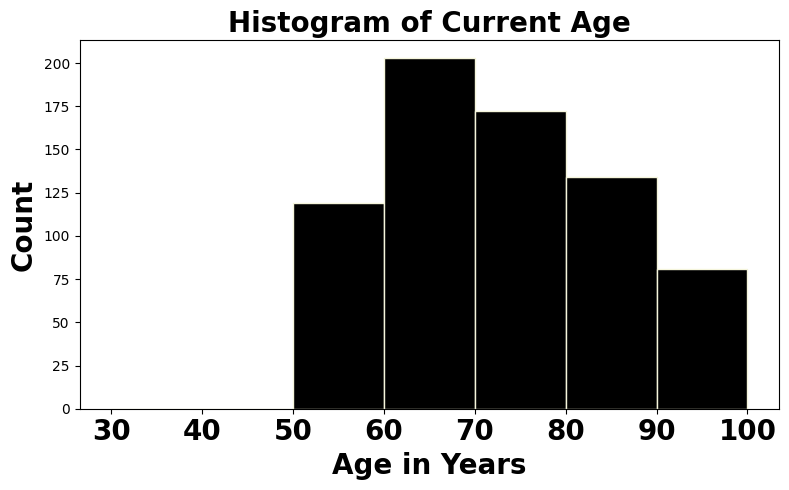

count    709.000000
mean      72.867597
std       11.643588
min       54.149213
25%       63.115674
50%       71.644079
75%       81.861739
max       95.143053
Name: current_age, dtype: float64


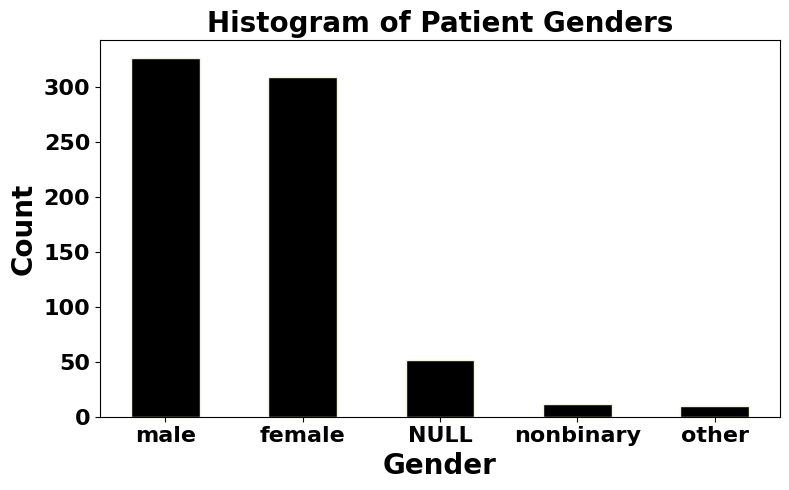

count      709
unique       5
top       male
freq       326
Name: gender, dtype: object


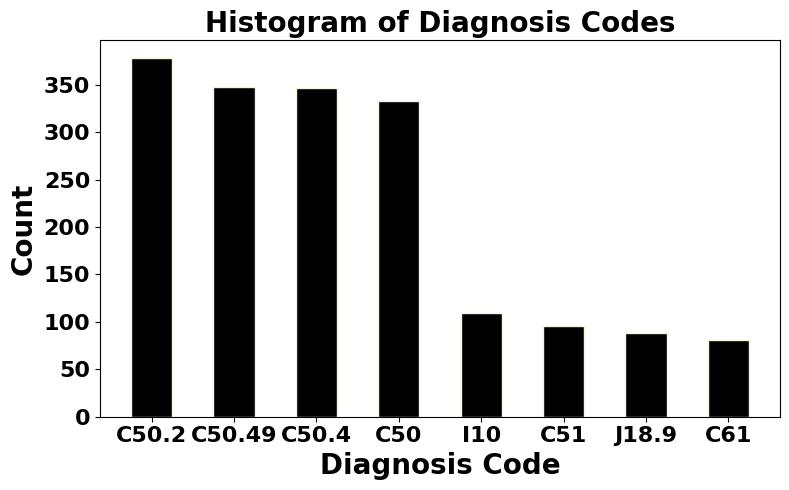

count      1780
unique        8
top       C50.2
freq        378
Name: diagnosis_code, dtype: object


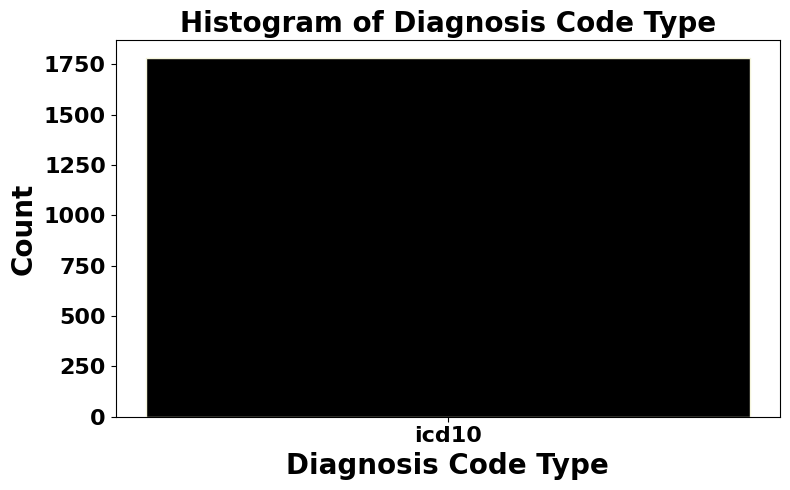

count      1780
unique        1
top       icd10
freq       1780
Name: diagnosis_code_type, dtype: object


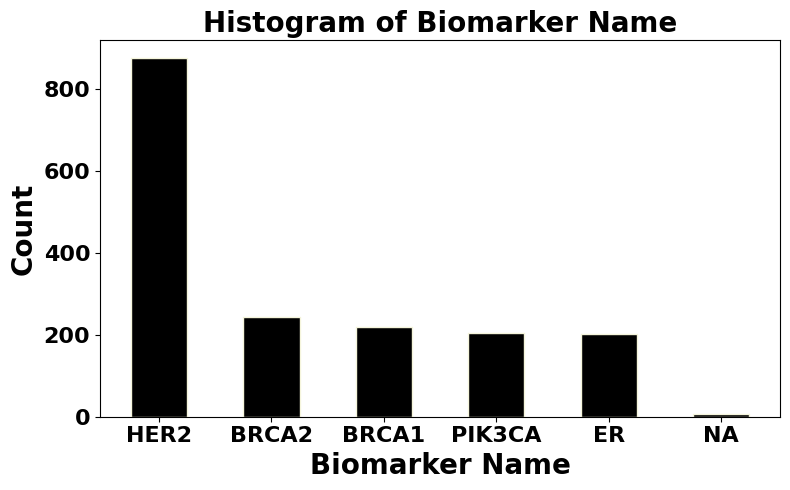

count     1753
unique       6
top       HER2
freq       875
Name: biomarker_name, dtype: object


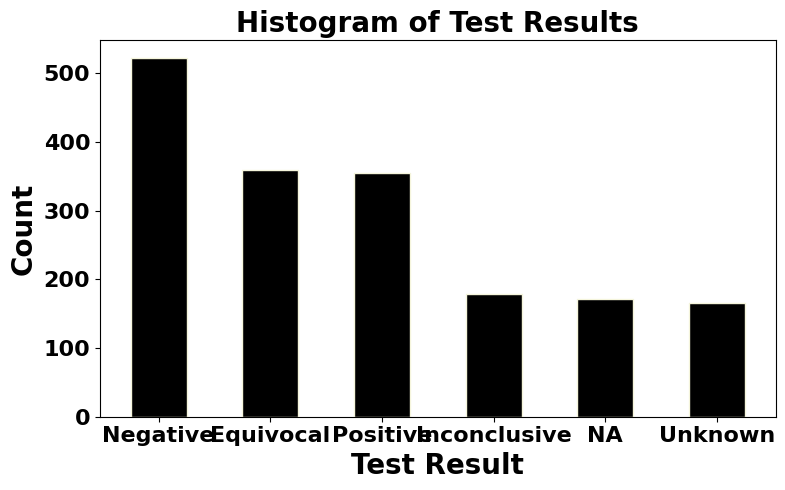

count         1753
unique           6
top       Negative
freq           522
Name: test_result, dtype: object


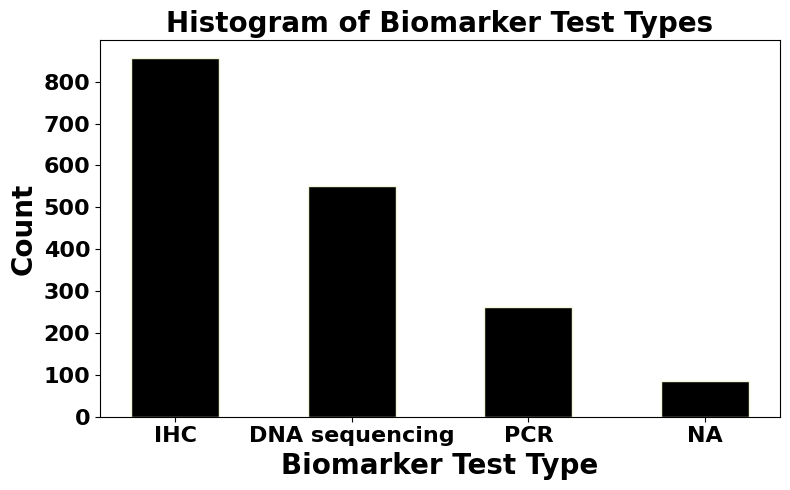

count     1753
unique       4
top        IHC
freq       856
Name: biomarker_test_type, dtype: object


In [11]:
#Patient's current age
patient['dob'] = pd.to_datetime(patient['dob'])
patient['current_age'] = (pd.to_datetime('2025-03-14') - patient['dob']).dt.days / 365.25
draw_hist_num(patient['current_age'], range(30,110,10), 'Age in Years', 'Count', 'Histogram of Current Age')
sum_stat(patient['current_age'])

#Gender
draw_hist_cat(patient, 'gender', 'Gender', 'Count', 'Histogram of Patient Genders')
sum_stat(patient['gender'])

#diagnosis code
draw_hist_cat(patient_diagnosis, 'diagnosis_code', 'Diagnosis Code', 'Count', 'Histogram of Diagnosis Codes')
sum_stat(patient_diagnosis['diagnosis_code'])

#diagnosis code type
draw_hist_cat(patient_diagnosis, 'diagnosis_code_type', 'Diagnosis Code Type', 'Count', 'Histogram of Diagnosis Code Type')
sum_stat(patient_diagnosis['diagnosis_code_type'])

#biomarker name
draw_hist_cat(patient_biomarker, 'biomarker_name', 'Biomarker Name', 'Count', 'Histogram of Biomarker Name')
sum_stat(patient_biomarker['biomarker_name'])

#test result
draw_hist_cat(patient_biomarker, 'test_result', 'Test Result', 'Count', 'Histogram of Test Results')
sum_stat(patient_biomarker['test_result'])

#test type
draw_hist_cat(patient_biomarker, 'biomarker_test_type', 'Biomarker Test Type', 'Count', 'Histogram of Biomarker Test Types')
sum_stat(patient_biomarker['biomarker_test_type'])

Writing the modified tables into a new database

In [12]:
conn_mod = sqlite3.connect(r"C:\work\database\techTest_mod.db")

patient.to_sql('patient_mod',con=conn_mod,schema='sqlite_schema',if_exists='replace',index=False)
patient_diagnosis.to_sql('patient_diagnosis',con=conn_mod,schema='sqlite_schema',if_exists='replace',index=False)
patient_biomarker.to_sql('patient_biomarker',con=conn_mod,schema='sqlite_schema',if_exists='replace',index=False)

conn_mod.commit()
conn_mod.close()

Function for Correlation

In [13]:
def corr(df, col):
    df_encoded = pd.get_dummies(df, columns=col)
    correlation_matrix = df_encoded.corr(method='spearman')
    print(correlation_matrix)

df1: patient ID, gender, current_age, age_at_initial_diagnosis, follow_up_time, event, survival_time

In [14]:

conn_mod = sqlite3.connect(r'C:\work\database\techTest_mod.db')

df1 = pd.read_sql("""
                  SELECT patient_id, MAX(diagnosis_date) AS last_encounter, MIN(diagnosis_date) AS initial_diagnosis 
                  FROM patient_diagnosis
                  GROUP BY patient_id
                  """, conn_mod)

df1 = pd.merge(patient, df1, on='patient_id')

df1['initial_diagnosis'] = pd.to_datetime(df1['initial_diagnosis'])
df1['last_encounter'] = pd.to_datetime(df1['last_encounter'])
df1['dob'] = pd.to_datetime(df1['dob'])
df1['dod'] = pd.to_datetime(df1['dod'])

df1['age_at_initial_diagnosis'] = (df1['initial_diagnosis'] - df1['dob']).dt.days / 365.25 #in years
df1['follow_up_time'] = (df1['last_encounter'] - df1['initial_diagnosis']).dt.days / 365.25

censor = pd.to_datetime('2024-01-01')  #arbitrary

df1['event'] = df1['dod'].apply(lambda x: 1 if pd.notnull(x) and x <= censor else 0)
df1['end_date'] = df1.apply(lambda row: row['dod'] if row['event'] == 1 else censor, axis=1)
df1['survival_time'] = (df1['end_date'] - df1['initial_diagnosis']).dt.days/365.25

df1 = df1.drop(columns=['dob', 'dod', 'last_encounter', 'initial_diagnosis', 'end_date'])

df2: patient ID, diagnosis code, age at diagnosis date merged with df1

In [15]:
patient_diagnosis['age_at_diagnosis_date'] = (patient_diagnosis['diagnosis_date'] - patient_diagnosis['dob']).dt.days / 365.25 #in years
patient_diagnosis1=patient_diagnosis.drop(columns=['dob', 'dod', 'gender', 'diagnosis_date', 'diagnosis_code_type'])
df2 = pd.merge(df1, patient_diagnosis1, on='patient_id')

df3: patient_id, biomarker_name, test_type, test_result, age_at_testing merged with df1

In [16]:
patient_biomarker['age_at_testing'] = (patient_biomarker['test_date'] - patient_biomarker['dob']).dt.days / 365.25
patient_biomarker1=patient_biomarker.drop(columns=['dob', 'dod', 'gender', 'test_date'])
df3 = pd.merge(df1, patient_biomarker1, on='patient_id')

Correlation

In [17]:
df2=df2.drop(columns=['patient_id'])
corr(df2,['gender', 'diagnosis_code'])

df3=df3.drop(columns=['patient_id'])
corr(df3,['gender', 'biomarker_name', 'biomarker_test_type', 'test_result'])

df1=df1.drop(columns=['patient_id'])
corr(df1,['gender'])

                          current_age  age_at_initial_diagnosis  \
current_age                  1.000000                  0.146095   
age_at_initial_diagnosis     0.146095                  1.000000   
follow_up_time               0.021048                 -0.373757   
event                        0.491591                  0.012291   
survival_time                0.176161                 -0.486249   
age_at_diagnosis_date        0.131626                  0.491196   
gender_NULL                 -0.029269                  0.007987   
gender_female                0.008306                 -0.058271   
gender_male                 -0.023964                  0.044496   
gender_nonbinary             0.042853                 -0.020990   
gender_other                 0.088969                  0.061392   
diagnosis_code_C50          -0.022371                 -0.021328   
diagnosis_code_C50.2         0.027776                 -0.000167   
diagnosis_code_C50.4         0.023572                 -0.02261

In [18]:
conn.close()
conn_mod.close()